# Reproducing Results from Visium Breast Cancer Spatial Transcriptomics Data
- by He Hui-Feng <huifeng@mails.ccnu.edu.cn>
- Last update: August 19th 2024



In this notebook, we will guide you in reproducing the experimental results of Visium Breast Cancer in the paper.
***

## Setup

- **Clone the HoVer-Net repository**: It is suggested to place the HoVer-Net repository in the root directory of PanoSpace. If another location is chosen, the HoVer-Net path will need to be manually specified during setup.
- **Set up the Conda environment**:Follow the instructions provided in the HoVer-Net repository to create the Conda environment required for training
- **Download the PanNuke pretrained weights**:The PanNuke pretrained weights will serve as the initial weights for HoVer-Net. The pretrained weights can be downloaded [here](https://drive.google.com/file/d/1SbSArI3KOOWHxRlxnjchO7_MbWzB4lNR/view). After downloading, create a `pretrained` folder in the root directory of the HoVer-Net repository. Place the weights file in this folder and ensure it is named `hovernet_fast_pannuke_type_tf2pytorch.tar`.
- **Download the Visium dataset**
A directory named `dataset/HBCDC` should be created under the root of the PanoSpace project. Then, navigate to this directory and run the following commands to download the Visium breast cancer dataset:

In [ ]:
cd dataset/HBCDC
wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif
wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_spatial.tar.gz
tar -xzf Visium_FFPE_Human_Breast_Cancer_spatial.tar.gz

- **Download the scRNA-seq reference dataset**
Downloading and extracting the single-cell reference data in the `dataset/HBCDC` directory:

In [ ]:
wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE176nnn/GSE176078/suppl/GSE176078%5FWu%5Fetal%5F2021%5FBRCA%5FscRNASeq.tar.gz
tar -xzf GSE176078_Wu_etal_2021_BRCA_scRNASeq.tar.gz

After completing the downloads, the directory structure should look like this:

In [ ]:
PanoSpace/
├── hover-net/
│   └── pretrained/
│       └── hovernet_fast_pannuke_type_tf2pytorch.tar
├── dataset/
│   └── HBCDC/
│       ├── Visium_FFPE_Human_Breast_Cancer_image.tif
│       ├── Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
│       ├── spatial/
│       │   ├── scalefactors_json.json
│       │   └── tissue_positions_list.csv
│       └── Wu_etal_2021_BRCA_scRNASeq/
│           ├── count_matrix_barcodes.tsv
│           ├── count_matrix_genes.tsv
│           ├── count_matrix_sparse.mtx
│           └── metadata.csv
└── ...

***

## Cell detector

The cell detector utilizes HoVer-Net for nuclei segmentation and classification. It takes a high-resolution HE-stained image as input and outputs an `h5ad` file containing the positions and morphological types of all nuclei across the entire image.

### training stage

To achieve more accurate segmentation, we recommend fine-tuning the HoVer-Net model on specific tissue types. For example, if you want to analyze breast cancer samples, you can fine-tune the pre-trained weights of HoVer-Net on the subset of data labeled as breast cancer in the PanNuke dataset. PanoSpace offers a streamlined way to train HoVer-Net.

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import json

import panospace as ps

import matplotlib.pyplot as plt

os.chdir('/home/hehf/Project/panospace')

os.getcwd()

'/home/hehf/Project/panospace'

In [ ]:

# Initialize the trainer. Specify pannuke_dir for the dataset location to download and focus for the tissue type to fine-tune on. `focus='all'` mean fine-tune the model with all PanNuke dataset.
# Available tissue types: 'Adrenal_gland','Bile-duct','Bladder','Breast','Cervix','Colon','Esophagus','HeadNeck',
# 'Kidney','Liver','Lung','Ovarian','Pancreatic','Prostate','Skin','Stomach','Testis','Thyroid','Uterus'
trainer = ps.train_hovernet(pannuke_dir = 'PanNuke', focus='Breast')

# The `download_pannuke()` method automatically downloads the PanNuke dataset to the specified directory.
trainer.download_pannuke()

# The `split_pannuke()` method divides the raw PanNuke dataset into training and validation sets, converting them into the required format for HoVer-Net.
trainer.split_pannuke()

# The `prepare_input()` method processes the PanNuke dataset into a format that HoVer-Net can use for training.
trainer.prepare_input()

# The `control_opt()` method updates the path to the pretrained weights in the HoVer-Net’s opt.py file. You can also do this manually if needed.
trainer.control_opt(hover_net_dir='hover_net')

# The `control_config()` method adjusts HoVer-Net’s configuration parameters in the config.py file according to your setup. You can also do this manually if needed.
trainer.control_config(hover_net_dir='hover_net')

# The `run_train()` method initiates the training process. Note that this will run in a subprocess, meaning no output feedback will be provided until completion. The process can take several hours, depending on your hardware. If you wish to monitor the training progress in real-time, manually run the `run_train.py` script following the HoVer-Net github.
trainer.run_train()

After completing this step, you can view the fine-tuned weights for the corresponding tissue type in the `hover_net/logs` directory:

In [ ]:
PanoSpace/
├── hover-net/
│   ├── pretrained/
│   │   └── hovernet_fast_pannuke_type_tf2pytorch.tar
│   ├── logs/
│   │   └── Breast/
│   │       └── 01/
│   │           └── net_epoch=50.tar
│   └── ...
└── ...

### Inference stage
After fine-tuning the network in the previous step, you can use the fine-tuned weights to perform nucleus segmentation and classification on a specific tissue type. In most cases, it is also possible to use the pretrained weights provided by HoVer-Net directly, depending on the segmentation results you are aiming for.

In [ ]:
# Initialize the `celldetector` object
# Arguments:
# - img_dir: Path to the tissue image.
# - tissue_name: A name to organize output directories.
# - small_image_size: Size of the tiles to split the image into.
# - hover_net_dir: Directory of the HoVer-Net repository.
# - resize: （Optional） scaling factor for the image tiles.
segmentor = ps.celldetector(
    img_dir='dataset/HBCDC/Visium_FFPE_Human_Breast_Cancer_image.tif',
    tissue_name='HBCDC',
    hover_net_dir='hover_net',
    small_image_size=(5000, 5000),
    resize=None
)

# Split the large image into smaller tiles
# This method splits the large tissue image into smaller tiles, saving them in the `dataset/tissue_name/imgs` directory.
# (Optional) arguments:
# - cvt: Whether to convert the image from RGB to BGR for OpenCV compatibility.
# - hue: optional hue shift to apply during splitting.
segmentor.split_img(cvt=False, hue=None)

# Run inference using HoVer-Net
# This method calls the HoVer-Net segmentation model on the split images. Note that this will run in a subprocess, meaning no output feedback will be provided until completion. The process can take several minutes, depending on your hardware. If you wish to monitor the progress in real-time, manually run the `run_tile.sh` script following the HoVer-Net github.
# This step will produce the standard output from HoVer-net, saving in the `dataset/tissue_name/pred` directory.
# Argument:
# - weight_dir: Path to the trained weights file for HoVer-Net.
segmentor.run_infer(weight_dir='logs/Breast/01/net_epoch=50.tar')

# Merge the segmented tiles back into a full image
# This method reassembles the segmented image tiles and generates a JSON file with contour and centroid data for each detected nucleus, which are saved in the `dataset/tissue_name/pred/out`
segmentor.merge_img()

# Generate an AnnData object from the segmentation results
# This method processes the segmentation results and creates an AnnData object for downstream analysis, which saved as `dataset/tissue_name/adata/img_adata_sc.h5ad`.
segmentor.make_nuclei_adata()


***
We can view the `h5ad` file with the location of the segmented cells and their corresponding morphological type：

In [9]:
img_adata_sc = sc.read_h5ad('dataset/HBCDC/adata/img_adata_sc.h5ad')
img_adata_sc

AnnData object with n_obs × n_vars = 53126 × 1
    obs: 'img_type'
    obsm: 'spatial'

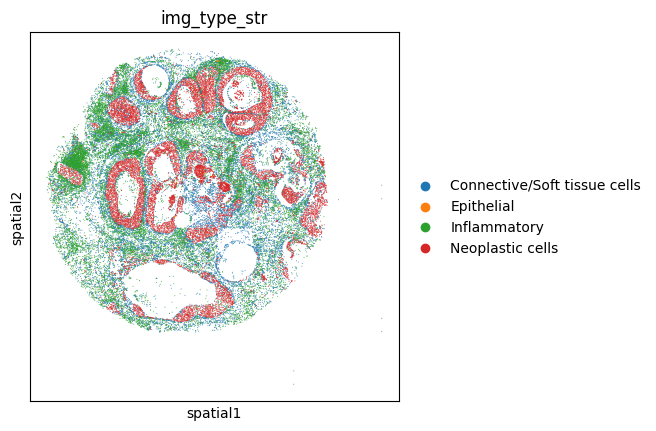

In [13]:
label_dict = {
    0 : 'nolabe', 
    1 : 'Neoplastic cells', 
    2 : 'Inflammatory', 
    3 : 'Connective/Soft tissue cells', 
    4 : 'Dead Cells', 
    5 : 'Epithelial' 
}

img_adata_sc.obs['img_type_str'] = img_adata_sc.obs['img_type'].map(label_dict)
sc.pl.spatial(img_adata_sc, color='img_type_str', spot_size=50)
plt.show()

***

## Cell type annotator

The Cell type annotator takes the h5ad file from the previous step, a high-resolution HE-stained image, and a spatial transcriptome h5ad file with deconvolution results as input. Its output is a cell type annotator that annotates each

We first perform deconvolution on the spatial transcriptomics data. Before that, we process the data using the following steps:

In [12]:
# Load 10x Visium data
adata = sc.read_10x_h5('dataset/HBCDC/Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
pos = pd.read_csv('dataset/HBCDC/spatial/tissue_positions_list.csv', header=None, index_col=0)
pos = pos.loc[adata.obs.index,]

adata.obsm['spatial'] = pos.iloc[:,[4,3]].values

# Save Visium data to CSV files
os.makedirs('dataset/HBCDC/to_decon', exist_ok=True)
st = pd.DataFrame(adata.X.T.todense(), index=adata.var_names, columns=adata.obs_names)
st.to_csv('dataset/HBCDC/to_decon/st.csv')
coor = pd.DataFrame(adata.obsm['spatial'], columns=['x','y'], index=adata.obs_names)
coor.to_csv('dataset/HBCDC/to_decon/coor.csv')

# Load single-cell RNA-seq data
count = sc.read('dataset/HBCDC/Wu_etal_2021_BRCA_scRNASeq/count_matrix_sparse.mtx')
barcode = pd.read_csv('dataset/HBCDC/Wu_etal_2021_BRCA_scRNASeq/count_matrix_barcodes.tsv', header=None)
genes = pd.read_csv('dataset/HBCDC/Wu_etal_2021_BRCA_scRNASeq/count_matrix_genes.tsv', header=None)
meta = pd.read_csv('dataset/HBCDC/Wu_etal_2021_BRCA_scRNASeq/metadata.csv', index_col=0)

count = count.T
count.obs_names = [a[0] for a in barcode.values]
count.var_names = [a[0] for a in genes.values]
com_gene = list(set(count.var_names).intersection(set(adata.var_names)))
count = count[:,com_gene]
count.obs = meta

# Create a sample of cells
cluster = count.obs.copy()
cluster_counts = count.obs['celltype_major'].value_counts()
sample_size = 2000
sample_index = []
for cluster_type in cluster_counts.index:
    cluster_data = cluster[cluster['celltype_major'] == cluster_type]
    if len(cluster_data) > sample_size:
        sampled_data = cluster_data.sample(n=sample_size, random_state=42)
    else:
        sampled_data = cluster_data
    sample_index+=sampled_data.index.tolist()
sample_index.sort()
sample_adata_sc = count[sample_index]
sample_adata_sc = sample_adata_sc[sample_adata_sc.to_df().sum(1)>10]

# Save single-cell RNA-seq data to CSV files
ref_cell_names = ['cell_'+str(i) for i in range(sample_adata_sc.shape[0])]
ref = pd.DataFrame(sample_adata_sc.X.T.todense(), index=sample_adata_sc.var_names, columns=ref_cell_names)
ref.to_csv('dataset/HBCDC/to_decon/ref.csv')
sc_meta = pd.DataFrame(sample_adata_sc.obs['celltype_major'].values, index=ref_cell_names, columns=['celltype_major'])
sc_meta.to_csv('dataset/HBCDC/to_decon/meta.csv')

sample_adata_sc.write('dataset/HBCDC/adata/sample_sc.h5ad')

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The data in `dataset/HBCDC/to_decon` can be used as input for EnDecon. EnDecon is an ensemble learning approach. For detailed usage, please refer to the [EnDecon GitHub page](https://github.com/keyalone/EnDecon). To balance runtime efficiency and accuracy, we incorporate RCTD, SpatialDWLS, and Cell2location as base methods, combining their results to achieve a consensus outcome.

For demonstration purposes, we provide the [results](https://zenodo.org/records/13341994) of EnDecon deconvolution. Please download the `ensemble_results_hbcdc.csv` file and place them in the `dataset/HBCDC/to_decon/EnDecon` directory (generally, you can choose any deconvolution method and organize the results in this format, as PanoSpace can accept it).

In [19]:
endecon = pd.read_csv('dataset/HBCDC/to_decon/EnDecon/ensemble_results.csv', index_col=0)
endecon.index = [i.replace('.','-') for i in endecon.index]

endecon_adata = adata.copy()[endecon.index]
endecon_adata.obs = endecon
sample_adata_sc.obs['celltype_major'] = sample_adata_sc.obs['celltype_major'].astype('category')
endecon_adata.uns['celltype'] = list(sample_adata_sc.obs['celltype_major'].cat.categories)
with open('dataset/HBCDC/spatial/scalefactors_json.json') as json_f:
    scalefactors = json.load(json_f)
endecon_adata.uns['radius'] = round(scalefactors['spot_diameter_fullres']*0.5)

endecon_adata.write('dataset/HBCDC/adata/EnDecon_adata.h5ad')

Next, we use the measurement spots as a training dataset to map histological image patches to their corresponding cellular compositions through a VGG16-based neural network, allowing us to infer the cellular composition across the entire query slice.

In [2]:
# Load
sample = 'HBCDC'
num_classes=9
Experimental_path = os.path.join('dataset',sample)
output_dir = os.path.join(Experimental_path,'celltype_infer')
img_dir = os.path.join(Experimental_path, 'Visium_FFPE_Human_Breast_Cancer_image.tif')
adata_dir = os.path.join(Experimental_path,'adata')
deconv_adata = sc.read(os.path.join(adata_dir,'EnDecon_adata.h5ad'))
segment_adata = sc.read(os.path.join(adata_dir,'img_adata_sc.h5ad'))

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
sr_inferencer=ps.superres_deconv(deconv_adata,
                                segment_adata,
                                img_dir,
                                Experimental_path,
                                neighb=2,
                                radius=deconv_adata.uns['radius'],
                                num_classes=num_classes)

sr_inferencer.run_train()
sr_inferencer.run_superres()

sr_deconv_adata = sr_inferencer.sr_adata
print(sr_deconv_adata)


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


model loaded...
loading super res data


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has T

Epoch 49: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, v_num=0, train_loss=0.318]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s, v_num=0, train_loss=0.318]


100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


AnnData object with n_obs × n_vars = 20023 × 1
    obs: 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    obsm: 'spatial'


In [3]:
sr_deconv_adata = sc.read('dataset/HBCDC/adata/sr_adata.h5ad')


inferencer = ps.celltypeannotator(experimental_path=Experimental_path,
                               img_dir=img_dir,
                               num_classes=9,
                               deconv_adata=deconv_adata,
                               sr_deconv_adata=sr_deconv_adata,
                               segment_adata=segment_adata,
                               lbd=0.5,
                               neighbor_size=2)

inferencer.filter_segmentation()
inferencer.calculate_cell_count()
inferencer.calculate_alpha()
inferencer.calculate_beta()
inferencer.calculate_type_transfer_matrix()
inferencer.infer_cell_types()


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 53110 × 1
    obs: 'img_type', 'pred_cell_type', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    obsm: 'spatial'

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


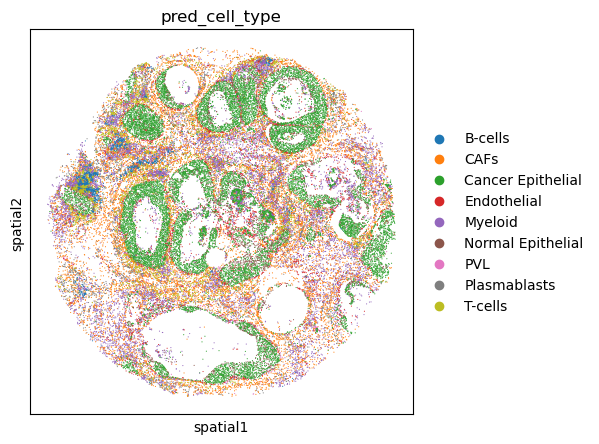

In [4]:
infered_adata = sc.read('dataset/HBCDC/celltype_infer/results/adata_0.5.h5ad')

fig, ax = plt.subplots(figsize=(5,5), sharey=True)
sc.pl.spatial(infered_adata, cmap='tab10', color='pred_cell_type', spot_size=50, ax=ax, colorbar_loc=None)
plt.savefig(os.path.join(output_dir,'fig','pred.png'), dpi=800, bbox_inches='tight')
plt.close()

In [11]:
sc_adata = sc.read(os.path.join(adata_dir,'sample_sc.h5ad'))

celltype_list=sc_adata.obs['celltype_major'].cat.categories
lbd=0.5
infered_adata = sc.read(os.path.join(output_dir,'results','adata_%s.h5ad'%str(lbd)))

gene_inferencer = ps.genexpredictor(sc_adata=sc_adata,
                                   spot_adata=deconv_adata,
                                   infered_adata=infered_adata)

gene_inferencer.ctspecific_spot_gene_exp(
    celltype_list=celltype_list,
    celltype_column='celltype_major'
)
genemap=gene_inferencer.do_geneinfer(lambda_param=0.1)

genemap.obs['pred_cell_type'] = genemap.obs['pred_cell_type'].astype('category')
for ct in genemap.obs['pred_cell_type'].cat.categories:
    genemap.obs[ct] = (genemap.obs['pred_cell_type']==ct).values.astype(int)
genemap.write(os.path.join(adata_dir, 'gene_map.h5ad'))


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/panospace/genexpression_predictor.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.cell_type_means = self.sc_adata.to_df().groupby(self.sc_adata.obs[celltype_column]).mean()
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/panospace/genexpression_predi

B-cells


Iterations Progress: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


CAFs


Iterations Progress: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Cancer Epithelial


Iterations Progress: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Endothelial


Iterations Progress: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Myeloid


Iterations Progress: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Normal Epithelial


Iterations Progress: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


PVL


Iterations Progress: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Plasmablasts


Iterations Progress: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


T-cells


Iterations Progress: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [3]:
genemap = sc.read(os.path.join(adata_dir, 'gene_map.h5ad'))

microenv_analyzer = ps.microenvironment_analyzer(genemap, Experimental_path)

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


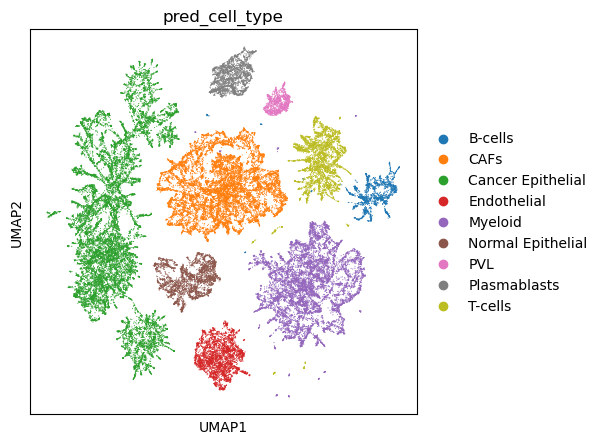

In [5]:
microenv_analyzer.umap()
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(microenv_analyzer.genemap, color='pred_cell_type', ax=ax, show=True)

In [4]:
microenv_analyzer.filter_gene(threshold=3)
microenv_analyzer.detect_microenvironment(search_radius=94)
microenv_analyzer.detect_env_gene(sender='CAFs', receiver='Cancer Epithelial', threshold=0.2)

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/panospace/microenvironment_analyzer.py:63: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.genexp_rec.obs['microenv_of_sender'] = sender_proportion


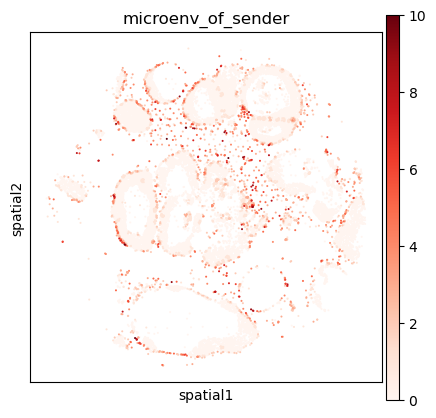

In [6]:
fig,ax=plt.subplots(figsize=(5,5))
sc.pl.spatial(microenv_analyzer.genexp_rec, color ='microenv_of_sender', spot_size=100,cmap='Reds',ax=ax)
plt.show()

In [12]:
target_genes = microenv_analyzer.detected_gene.index.to_list()
print(len(target_genes))
target_genes[:20]

95


['ALDH2',
 'SLC38A10',
 'TIMP3',
 'LDLRAD4',
 'ILF3',
 'SIPA1',
 'CRYAB',
 'CIRBP',
 'YPEL3',
 'NDUFS5',
 'CDC42EP5',
 'HIST1H4H',
 'FKBP10',
 'IGF1R',
 'ELL2',
 'ANPEP',
 'HSPB1',
 'MRAS',
 'BUB3',
 'FSCN1']

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


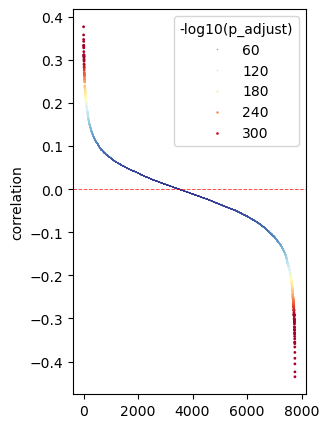

In [14]:
microenv_analyzer.plot_rank_order()

import seaborn as sns
fig, ax = plt.subplots(figsize=(3,5))
sns.scatterplot(data=microenv_analyzer.plot_df, x=np.arange(microenv_analyzer.plot_df.shape[0]), y='correlation',edgecolor='none',ax=ax,hue='-log10(p_adjust)', palette='RdYlBu_r', size='-log10(p_adjust)', sizes=(0.4, 4),legend=True)
plt.axhline(0, linestyle='--', color='red', linewidth=0.7, alpha=0.7)
plt.show()

In [5]:
genemap = sc.read(os.path.join(adata_dir, 'gene_map.h5ad'))

microenv_analyzer.load_contour_list()
microenv_analyzer.prepare_plot_ligrec(genemap,sender='CAFs',receiver='Cancer Epithelial',ligand='EFNB1',receptor='ERBB2', plot_num=20000)

import cv2
img = cv2.imread('dataset/HBCDC/Visium_FFPE_Human_Breast_Cancer_image.tif')
img_adata = sc.read('dataset/HBCDC/adata/img_adata_sc.h5ad')
img = microenv_analyzer.plot_ligrec(genemap,img,img_adata)

/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


19999


/home/hehf/anaconda3/envs/panospace_test/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


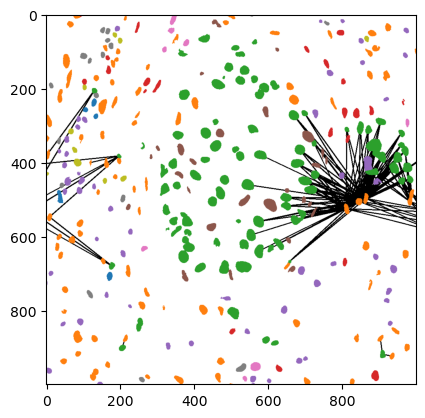

In [6]:
img_crop = img[13500:14500,17500:18500]
plt.imshow(img_crop)


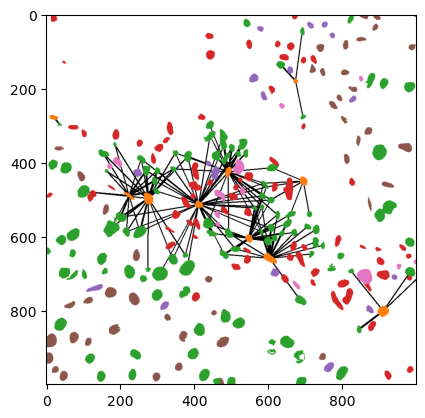

In [7]:
img_crop = img[13250:14250,14530:15530]
plt.imshow(img_crop)

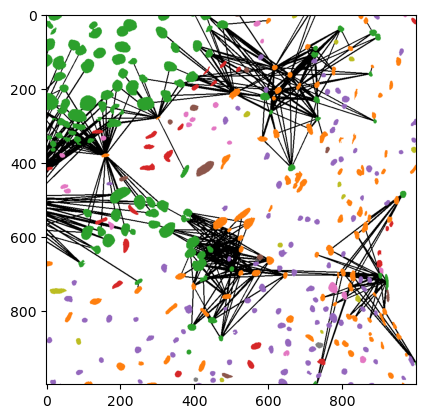

In [8]:
img_crop = img[8500:9500,15000:16000]
plt.imshow(img_crop)